# 📊 Bank Marketing Analysis & Client Subscription Prediction
### Modern Data Analysis + Machine Learning + Power BI Dashboard

This project analyzes the **Bank Marketing Dataset**, focusing on identifying which clients are most likely to subscribe to a term deposit.

The workflow simulates an industry-level analytics process used by real data analysts:

### 🔍 What This Notebook Includes
- Modern, professional **Exploratory Data Analysis (EDA)**
- Data quality evaluation
- Visualization best practices (2024–2025)
- Six machine learning models
- Confusion matrices + ROC curves + AUC
- Feature importance + SHAP explainability
- A Power BI business dashboard
- End-to-end pipeline ready for GitHub

This notebook is structured for:
- **Class presentation**
- **Junior data analyst interviews**
- **Portfolio showcasing**


In [2]:
!pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

sns.set_theme(style="whitegrid")

In [33]:
#Load the CSV
df = pd.read_csv("bank-additional-full.csv", sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
#Explore the data
df.info()
df.describe(include="all").T
df["y"].value_counts()
df["y"].value_counts(normalize=True) * 100


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,proportion
y,
no,88.734583
yes,11.265417


## 2. Data Quality Check & Dataset Structure

Before modeling, we perform data quality checks used by professional analysts:

- Missing values
- Duplicate records
- “unknown” placeholder values
- Numeric summary statistics
- Categorical variable overview


In [6]:
# Missing values count
missing = df.isnull().sum().sort_values(ascending=False)
missing
#Duplicate checking
duplicates = df.duplicated().sum()
duplicates
#Check for “unknown” category
unknown_counts = (df == "unknown").sum().sort_values(ascending=False)
unknown_counts

,0
default,8597
education,1731
housing,990
loan,990
job,330
marital,80
age,0
contact,0
month,0
day_of_week,0


## 3. Univariate Analysis (Distributions)
Understanding the shape of numeric and categorical features helps identify
patterns and potential issues.

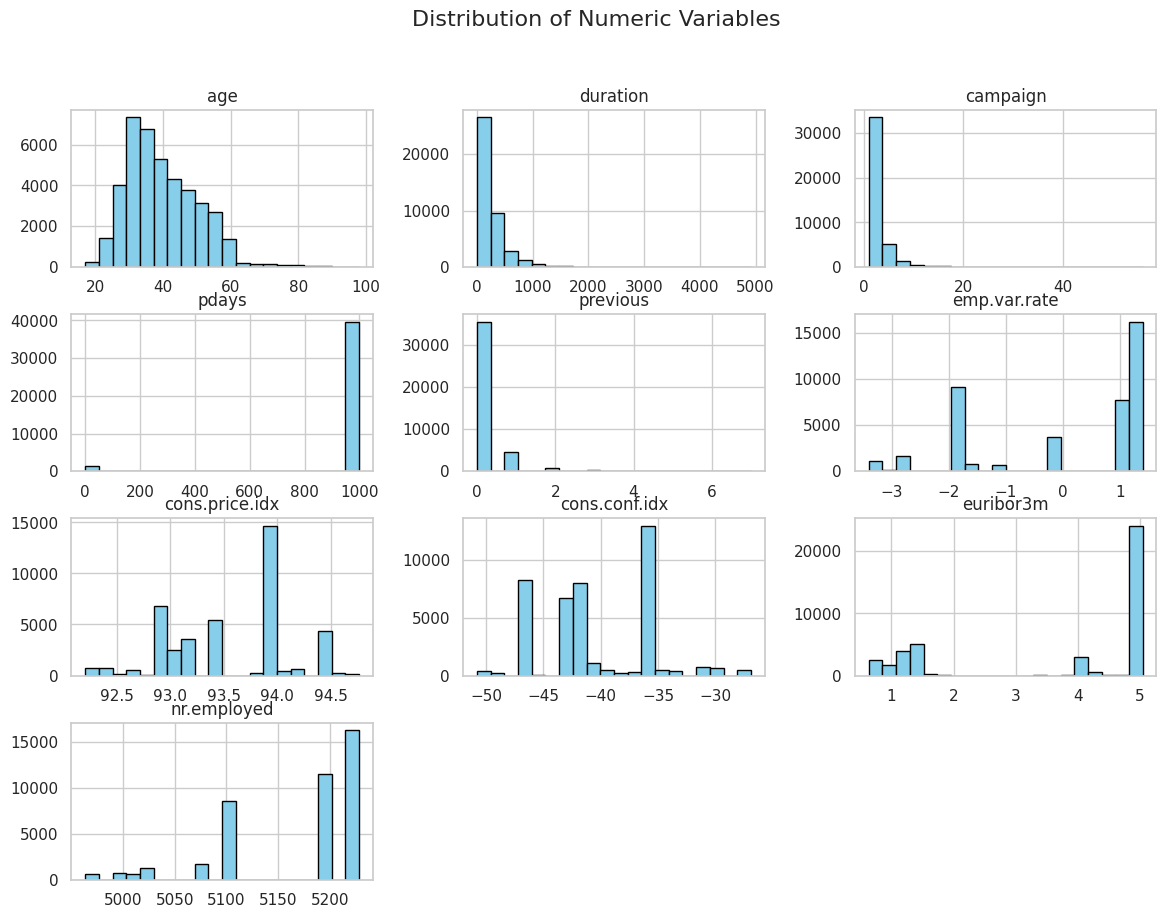

In [7]:
#Numeric Distributions
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[numeric_cols].hist(bins=20, figsize=(14, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Numeric Variables", fontsize=16)
plt.show()

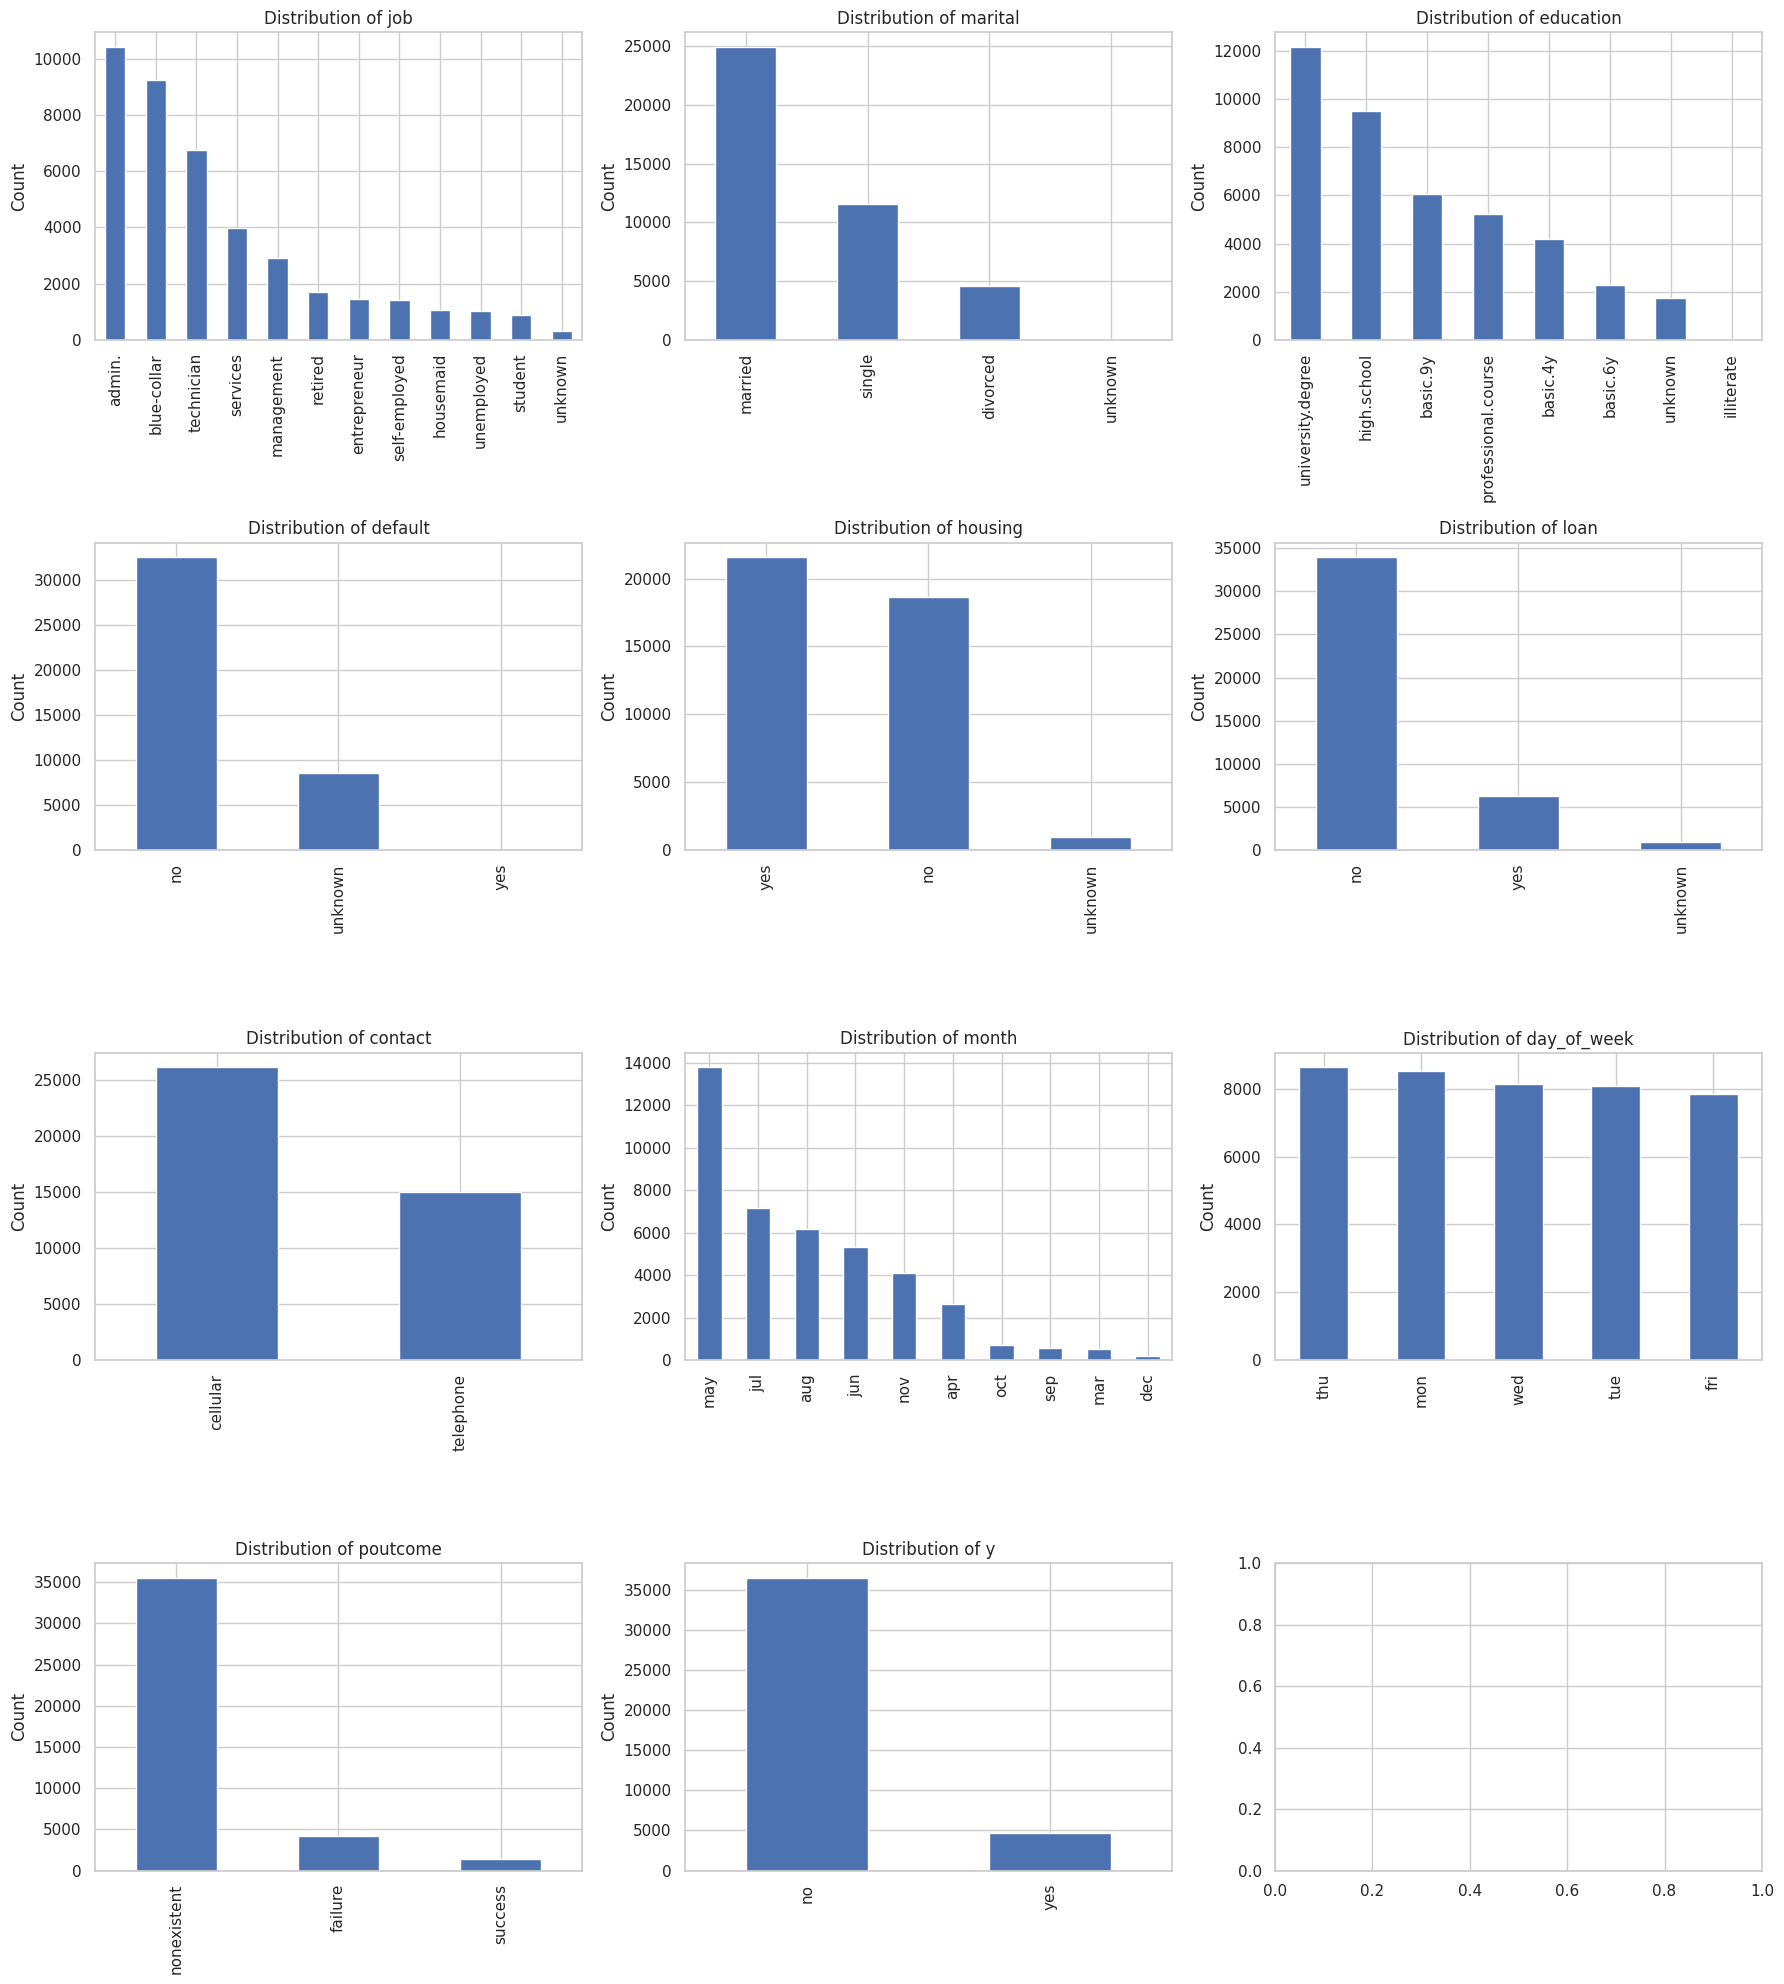

In [8]:
#Categorical Distributions
categorical_cols = df.select_dtypes(include=['object']).columns

fig, axes = plt.subplots(len(categorical_cols)//3+1, 3, figsize=(18,20))
axes = axes.flatten()

for ax, col in zip(axes, categorical_cols):
    df[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel("")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

## 4. Target Variable Analysis
The target variable **y** indicates whether a client subscribed to a term deposit.
Understanding class imbalance is critical for ML model evaluation.

/tmp/ipython-input-3168088218.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["y"], palette="flare")


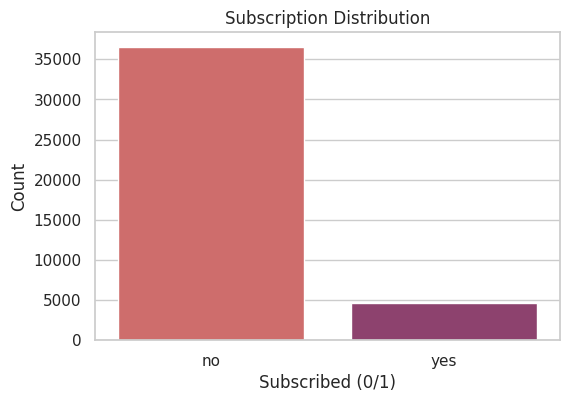

,proportion
y,
no,88.734583
yes,11.265417


In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["y"], palette="flare")
plt.title("Subscription Distribution")
plt.xlabel("Subscribed (0/1)")
plt.ylabel("Count")
plt.show()

df["y"].value_counts(normalize=True) * 100

## 5. Bivariate Analysis — What Drives Subscription?

We evaluate how key features influence subscription rate:
- job
- contact method
- month
- call duration
- number of contacts

/tmp/ipython-input-591493362.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=job_rates.values, y=job_rates.index, palette="crest")


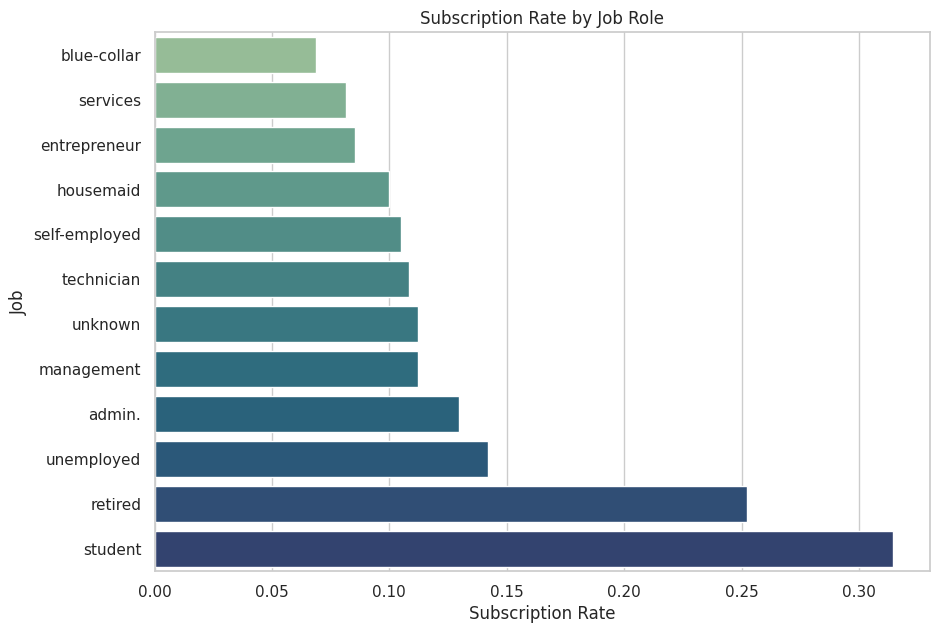

In [10]:
#Subscription Rate by Job
job_rates = (
    df.groupby('job')['y']
      .value_counts(normalize=True)
      .unstack(fill_value=0)['yes']   # proportion of "yes"
      .sort_values()
)

plt.figure(figsize=(10,7))
sns.barplot(x=job_rates.values, y=job_rates.index, palette="crest")
plt.title("Subscription Rate by Job Role")
plt.xlabel("Subscription Rate")
plt.ylabel("Job")
plt.show()


/tmp/ipython-input-3126024674.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contact_rates.index, y=contact_rates.values, palette="deep")


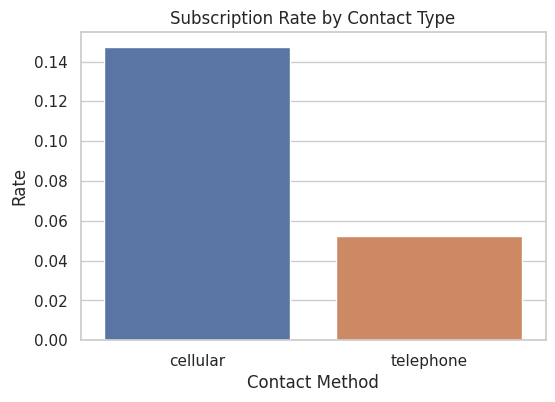

In [11]:
#Subscription Rate by Contact Communication
contact_rates = (
    df.groupby('contact')['y']
      .value_counts(normalize=True)
      .unstack()
      ['yes']
)

plt.figure(figsize=(6,4))
sns.barplot(x=contact_rates.index, y=contact_rates.values, palette="deep")
plt.title("Subscription Rate by Contact Type")
plt.xlabel("Contact Method")
plt.ylabel("Rate")
plt.show()

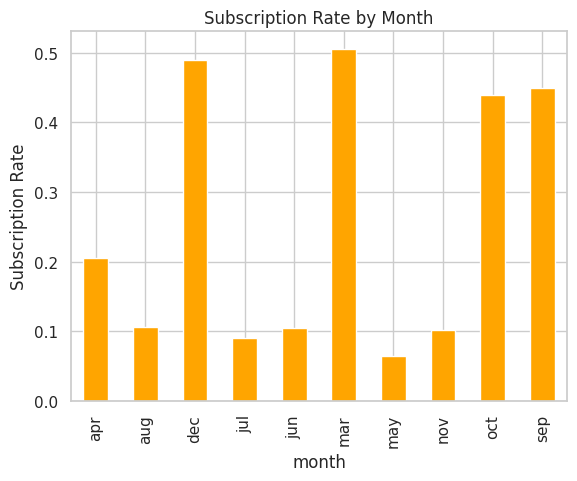

In [12]:
#Subscription Rate by Month
month_rates = df.groupby('month')['y'].value_counts(normalize=True).unstack()['yes']

month_rates.plot(kind='bar', color='orange')
plt.title("Subscription Rate by Month")
plt.ylabel("Subscription Rate")
plt.show()

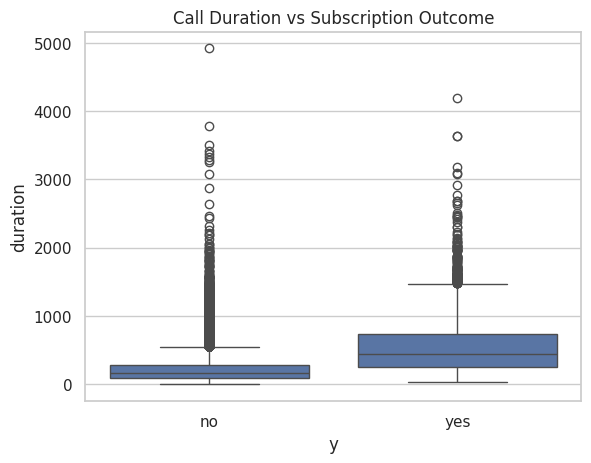

In [13]:
#Relationship: Duration vs Subscription
sns.boxplot(x='y', y='duration', data=df)
plt.title("Call Duration vs Subscription Outcome")
plt.show()

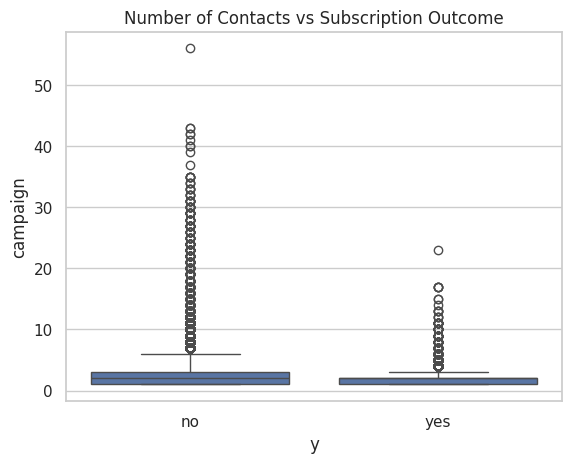

In [ ]:
#Relationship: Number of Contacts (campaign) vs Subscription
sns.boxplot(x='y', y='campaign', data=df)
plt.title("Number of Contacts vs Subscription Outcome")
plt.show()

## 6. Correlation Heatmap (Numeric Features)

Used to identify multicollinearity and relationships between key features.

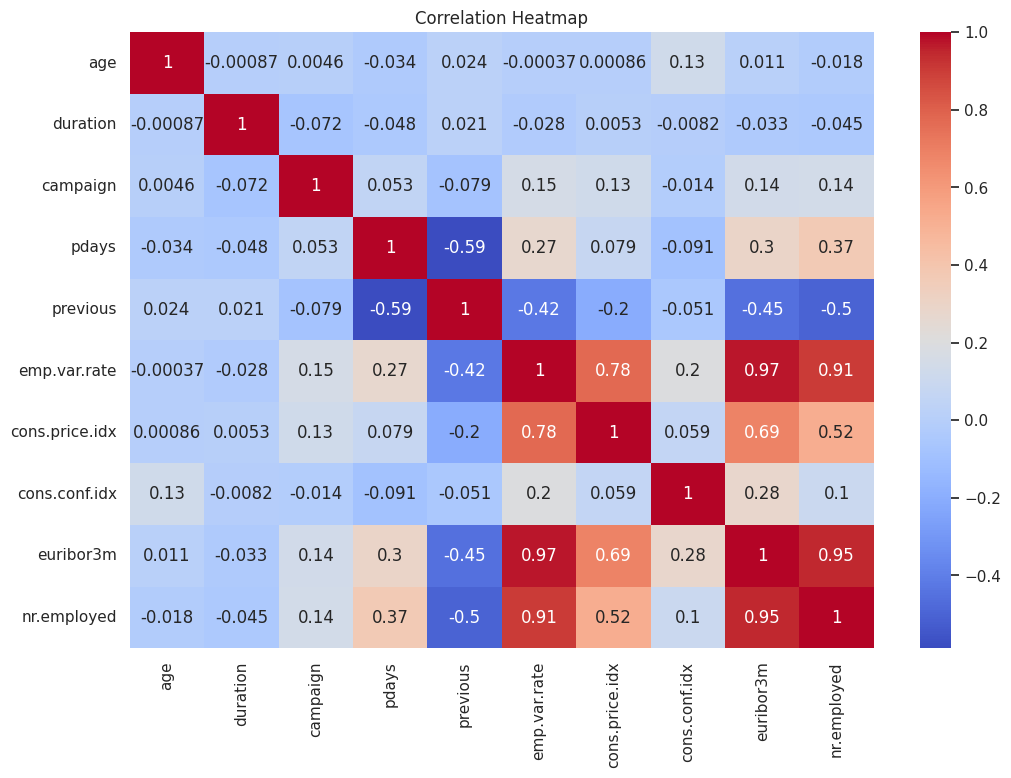

In [14]:
#Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## 7. Data Preprocessing for Machine Learning

After completing exploratory analysis, we prepare the dataset for modeling:

- Encode categorical variables
- Convert target variable to binary (0/1)
- Create training and testing splits
- Standardize numerical features

These preprocessing steps ensure the models receive clean and meaningful input data.

In [15]:
# Encode target variable
df["y"] = (df["y"] == "yes").astype(int)

# Separate features and target
X = df.drop("y", axis=1)
y = df["y"]

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

# Scale numeric features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 8. Machine Learning Models

We build six classification models commonly used in industry:

1. Logistic Regression  
2. Naive Bayes  
3. K-Nearest Neighbors  
4. Decision Tree  
5. Random Forest  
6. XGBoost  

All models are trained using default (or near-default) parameters as required by the assignment.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss"
    )
}

## 9. Model Training & Evaluation (Modern Analyst Style)

For each model, we compute:

- Accuracy  
- Precision  
- Recall  
- F1 Score  
- ROC-AUC  
- Confusion Matrix (heatmap)  
- ROC Curve  

We store all results in a metrics table for clear comparison.

Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10965
           1       0.67      0.42      0.52      1392

    accuracy                           0.91     12357
   macro avg       0.80      0.70      0.74     12357
weighted avg       0.90      0.91      0.90     12357

Accuracy:  0.9120
Precision: 0.6743
Recall:    0.4224
F1 Score:  0.5194
AUC:       0.9383


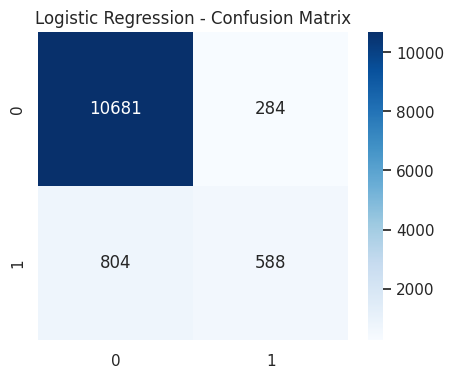

Naive Bayes
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     10965
           1       0.29      0.82      0.43      1392

    accuracy                           0.76     12357
   macro avg       0.63      0.78      0.64     12357
weighted avg       0.89      0.76      0.80     12357

Accuracy:  0.7569
Precision: 0.2924
Recall:    0.8154
F1 Score:  0.4304
AUC:       0.8454


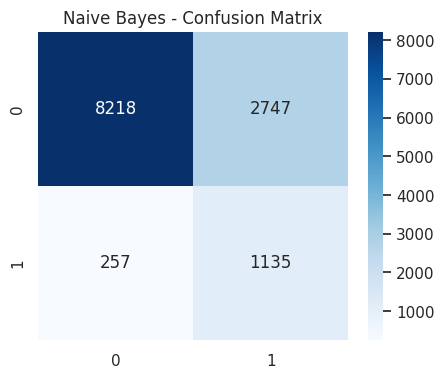

KNN
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     10965
           1       0.61      0.33      0.43      1392

    accuracy                           0.90     12357
   macro avg       0.77      0.65      0.69     12357
weighted avg       0.89      0.90      0.89     12357

Accuracy:  0.9011
Precision: 0.6142
Recall:    0.3283
F1 Score:  0.4279
AUC:       0.8191


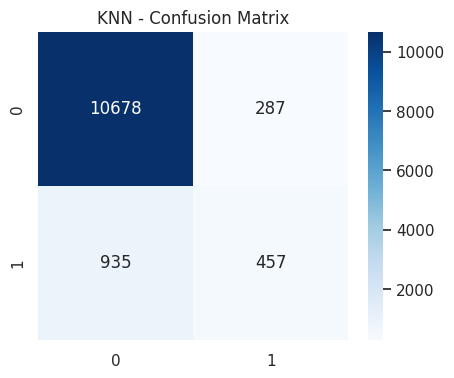

Decision Tree
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10965
           1       0.51      0.53      0.52      1392

    accuracy                           0.89     12357
   macro avg       0.73      0.73      0.73     12357
weighted avg       0.89      0.89      0.89     12357

Accuracy:  0.8900
Precision: 0.5115
Recall:    0.5280
F1 Score:  0.5196
AUC:       0.7320


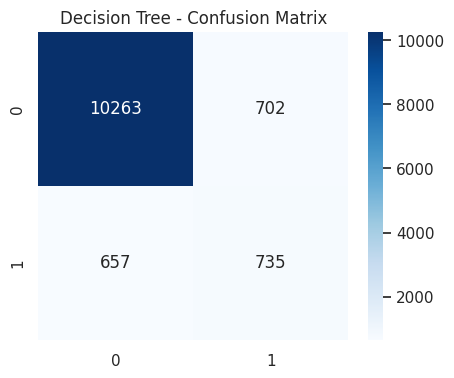

Random Forest
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10965
           1       0.67      0.48      0.56      1392

    accuracy                           0.92     12357
   macro avg       0.80      0.73      0.76     12357
weighted avg       0.91      0.92      0.91     12357

Accuracy:  0.9154
Precision: 0.6733
Recall:    0.4828
F1 Score:  0.5623
AUC:       0.9451


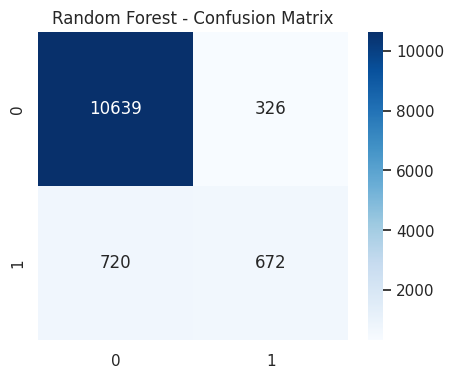

XGBoost
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10965
           1       0.66      0.54      0.59      1392

    accuracy                           0.92     12357
   macro avg       0.80      0.75      0.77     12357
weighted avg       0.91      0.92      0.91     12357

Accuracy:  0.9163
Precision: 0.6576
Recall:    0.5366
F1 Score:  0.5910
AUC:       0.9494


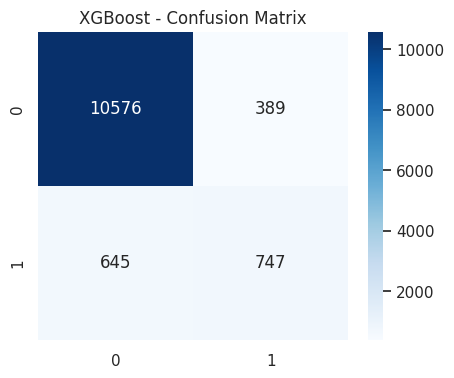

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score, classification_report
)

results = []
roc_data = {}

for name, model in models.items():
    print("="*80)
    print(name)
    print("="*80)

    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)

    results.append([name, acc, prec, rec, f1, auc])

    print(classification_report(y_test, y_pred))
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ROC Data
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_data[name] = (fpr, tpr, auc)

In [19]:
#Comparison Table
results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]
).sort_values("AUC", ascending=False)

results_df.style.background_gradient(cmap="Blues")

,Model,Accuracy,Precision,Recall,F1,AUC
5,XGBoost,0.916323,0.657570,0.536638,0.590981,0.949365
4,Random Forest,0.915352,0.673347,0.482759,0.562343,0.945146
0,Logistic Regression,0.911953,0.674312,0.422414,0.519435,0.938265
1,Naive Bayes,0.756899,0.292375,0.815374,0.430413,0.845430
2,KNN,0.901109,0.614247,0.328305,0.427903,0.819079
3,Decision Tree,0.890022,0.511482,0.528017,0.519618,0.731998


## 10. Unified ROC Curve Comparison

Plotting all ROC curves on a single chart gives a clean, direct comparison of
model performance.

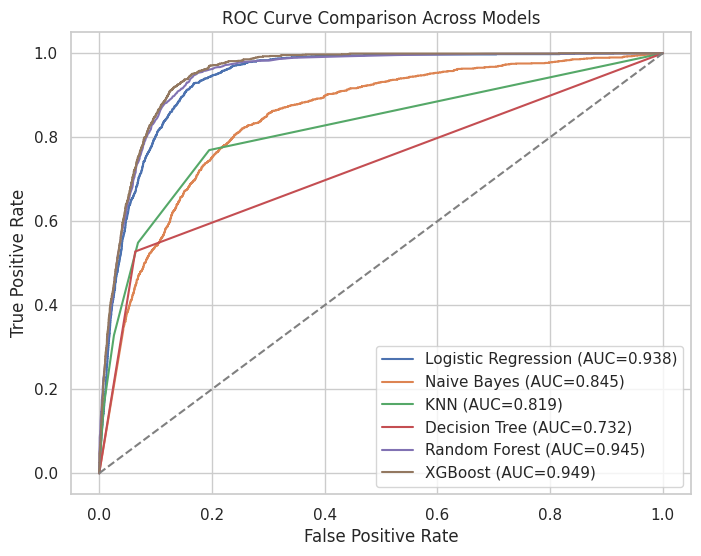

In [18]:
plt.figure(figsize=(8,6))

for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC Curve Comparison Across Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [20]:
import pandas as pd
import numpy as np

# ------------------ EXPORT MODEL PERFORMANCE TABLE ------------------

model_performance_df = pd.DataFrame(
    results,   # <-- FIXED (your file uses `results`, not model_results)
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]
)

model_performance_df.to_csv("model_performance.csv", index=False)

# ------------------ EXPORT UNIFIED ROC TABLE ------------------

roc_rows = []
for name, (fpr, tpr, auc) in roc_data.items():
    for fp, tp in zip(fpr, tpr):
        roc_rows.append([name, fp, tp])

roc_df = pd.DataFrame(roc_rows, columns=["Model", "FPR", "TPR"])
roc_df.to_csv("roc_curves.csv", index=False)

# ------------------ EXPORT CONFUSION MATRICES ------------------

confusion_output = []

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    confusion_output.append([name, 0, 0, cm[0][0]])  # TN
    confusion_output.append([name, 0, 1, cm[0][1]])  # FP
    confusion_output.append([name, 1, 0, cm[1][0]])  # FN
    confusion_output.append([name, 1, 1, cm[1][1]])  # TP

cm_df = pd.DataFrame(confusion_output, columns=["Model", "Actual", "Predicted", "Count"])
cm_df.to_csv("confusion_matrices.csv", index=False)

# ------------------ EXPORT FEATURE IMPORTANCE ------------------

rf_model = models["Random Forest"]
rf_importance = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Importance": rf_model.feature_importances_,
    "Model": "Random Forest"
})

xgb_model = models["XGBoost"]
xgb_importance = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Importance": xgb_model.feature_importances_,
    "Model": "XGBoost"
})

fi_df = pd.concat([rf_importance, xgb_importance], axis=0)
fi_df.to_csv("feature_importance.csv", index=False)

print("EXPORT COMPLETE:")
print("- model_performance.csv")
print("- roc_curves.csv")
print("- confusion_matrices.csv")
print("- feature_importance.csv")


EXPORT COMPLETE:
- model_performance.csv
- roc_curves.csv
- confusion_matrices.csv
- feature_importance.csv


## 11. Model Explainability (Feature Importance & SHAP)

Feature importance helps stakeholders understand **why** the model makes certain predictions.

We include:
- Random Forest feature importance
- XGBoost feature importance
- SHAP summary plots for interpretability

/tmp/ipython-input-2764253203.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x="importance", y="feature", palette="viridis")


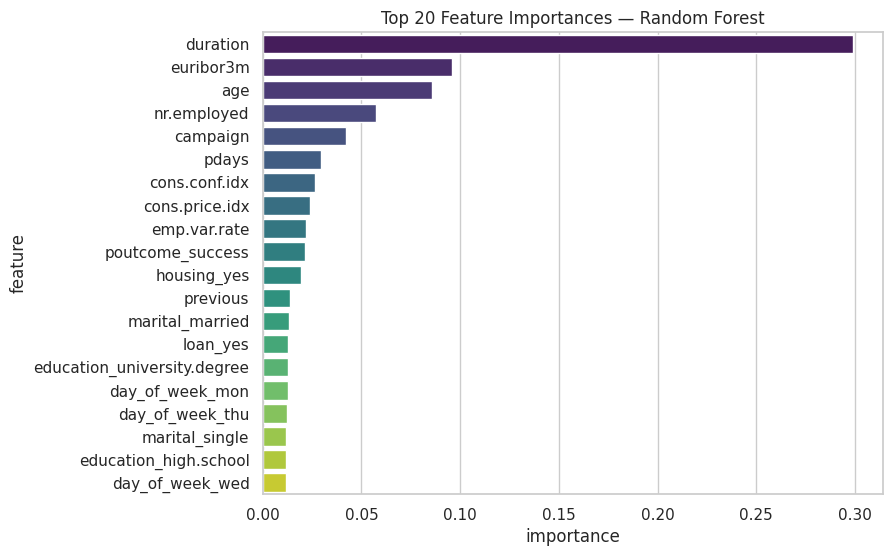

/tmp/ipython-input-2764253203.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x="importance", y="feature", palette="viridis")


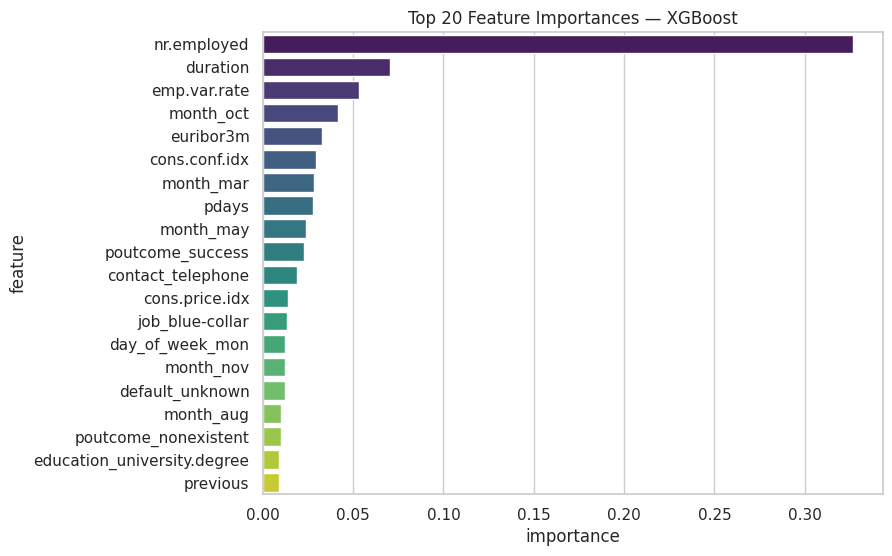

In [21]:
def plot_feature_importance(model, X, name):
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
        feat_df = pd.DataFrame({
            "feature": X.columns,
            "importance": importance
        }).sort_values("importance", ascending=False).head(20)

        plt.figure(figsize=(8,6))
        sns.barplot(data=feat_df, x="importance", y="feature", palette="viridis")
        plt.title(f"Top 20 Feature Importances — {name}")
        plt.show()

plot_feature_importance(models["Random Forest"], X_encoded, "Random Forest")
plot_feature_importance(models["XGBoost"], X_encoded, "XGBoost")

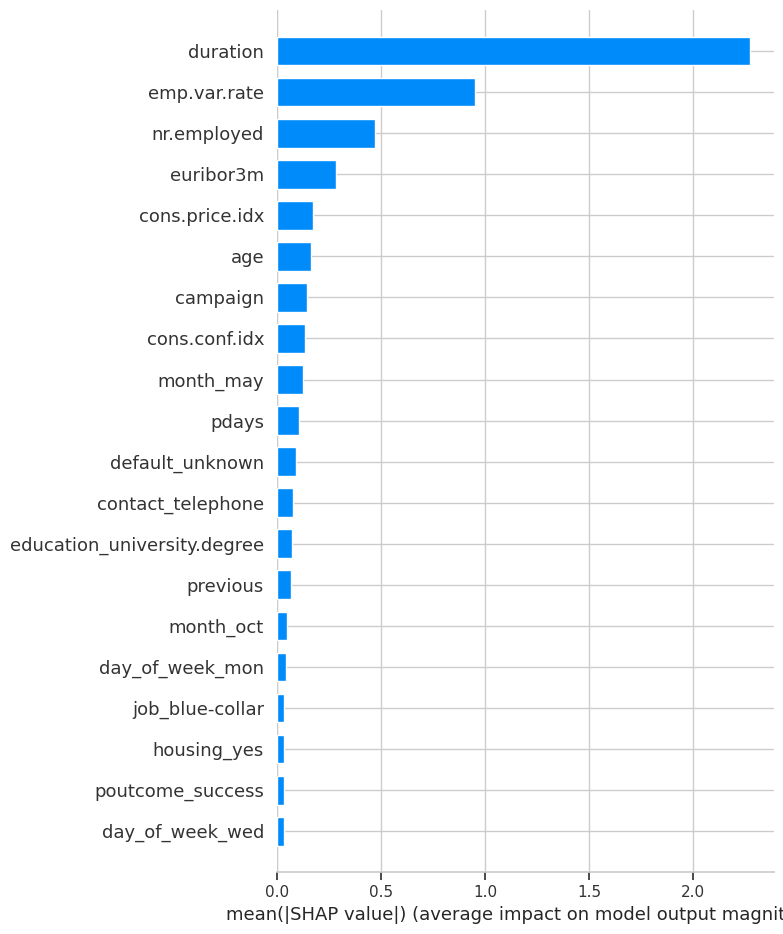

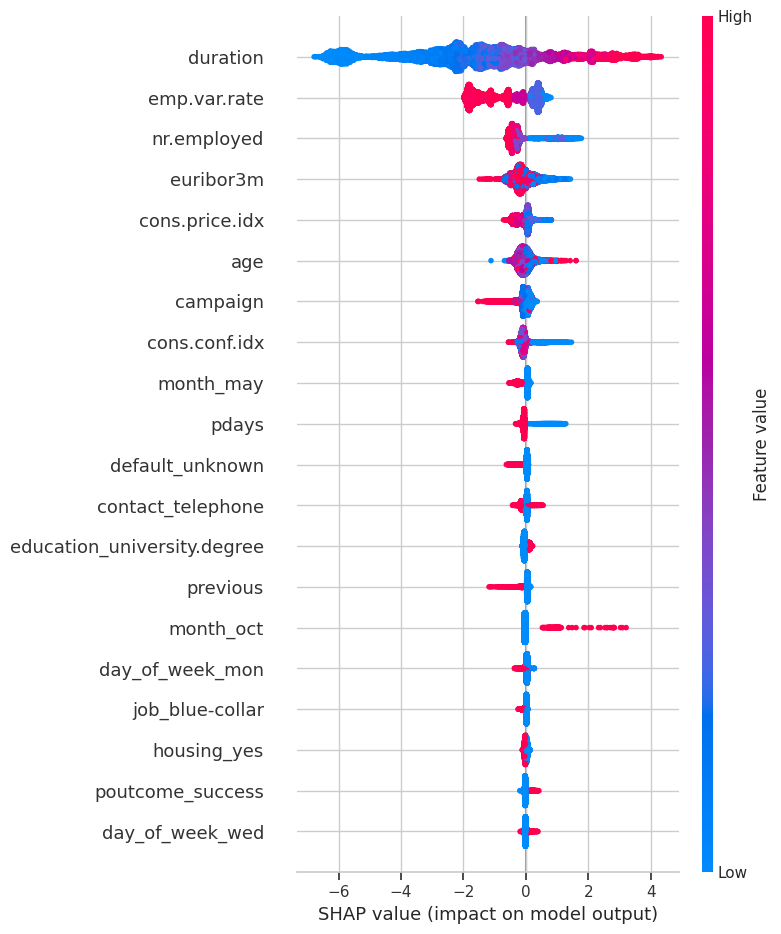

In [22]:
#SHAP
!pip install shap
import shap

explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

In [23]:
import pandas as pd
import numpy as np

# ------------ SHAP SUMMARY EXPORT (Top 20 features) ------------

# shap_values = explainer(X_test_scaled)

shap_df = pd.DataFrame({
    "Feature": X_test.columns,
    "SHAP Importance": np.abs(shap_values.values).mean(axis=0)
})

shap_df = shap_df.sort_values("SHAP Importance", ascending=False).head(20)
shap_df.to_csv("shap_feature_importance.csv", index=False)

# ------------ PARTIAL DEPENDENCY STYLE EXPORTS ------------

# AGE vs SUBSCRIPTION RATE
age_effect = df.groupby("age")["y"].mean().reset_index()
age_effect.to_csv("age_effect.csv", index=False)

# DURATION vs SUBSCRIPTION RATE (binned)
df["duration_bin"] = pd.qcut(df["duration"], q=10)
duration_effect = df.groupby("duration_bin")["y"].mean().reset_index()
duration_effect.to_csv("duration_effect.csv", index=False)

# JOB vs SUBSCRIPTION RATE (already used but helpful here)
job_effect = df.groupby("job")["y"].mean().reset_index()
job_effect.to_csv("job_effect.csv", index=False)

# CONTACT × DURATION (interaction)
contact_duration = df.groupby("contact")["duration"].mean().reset_index()
contact_duration.to_csv("contact_duration.csv", index=False)

print("EXPORTS COMPLETE:")
print(" - shap_feature_importance.csv")
print(" - age_effect.csv")
print(" - duration_effect.csv")
print(" - job_effect.csv")
print(" - contact_duration.csv")


EXPORTS COMPLETE:
 - shap_feature_importance.csv
 - age_effect.csv
 - duration_effect.csv
 - job_effect.csv
 - contact_duration.csv


/tmp/ipython-input-2783904315.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_effect = df.groupby("duration_bin")["y"].mean().reset_index()


## 12. Hyperparameter Tuning (Random Forest)

Using GridSearchCV to improve model performance.

In [24]:
#Sort model results
sorted(results, key=lambda x: x[1], reverse=True)

[['XGBoost',
  0.9163227320547058,
  0.6575704225352113,
  0.5366379310344828,
  0.5909810126582279,
  np.float64(0.9493650774931731)],
 ['Random Forest',
  0.9153516225621106,
  0.6733466933867736,
  0.4827586206896552,
  0.5623430962343097,
  np.float64(0.9451459319359928)],
 ['Logistic Regression',
  0.911952739338027,
  0.6743119266055045,
  0.4224137931034483,
  0.519434628975265,
  np.float64(0.9382647766404075)],
 ['KNN',
  0.9011086833373796,
  0.614247311827957,
  0.32830459770114945,
  0.42790262172284643,
  np.float64(0.8190791232290832)],
 ['Decision Tree',
  0.8900218499635834,
  0.511482254697286,
  0.5280172413793104,
  0.5196182396606575,
  np.float64(0.7319976767772066)],
 ['Naive Bayes',
  0.7568989236869791,
  0.29237506439979394,
  0.8153735632183908,
  0.4304133485020857,
  np.float64(0.8454296520800247)]]

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_dist_rf = {
    "n_estimators": [200, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "class_weight": ["balanced", "balanced_subsample"]
}

rf = RandomForestClassifier(random_state=42)

rand_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=25,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rand_rf.fit(X_train_scaled, y_train)

print("Best RF Params:", rand_rf.best_params_)
print("Best RF F1 Score:", rand_rf.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best RF Params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'class_weight': 'balanced_subsample'}
Best RF F1 Score: 0.6433936033175188


**XGBoost Hyperparameter Tuning**

In [31]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist_xgb = {
    "n_estimators": [200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 1],
    "scale_pos_weight": [1, 7, 10]   # IMPORTANT for imbalance
}

xgb = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

rand_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist_xgb,
    n_iter=25,              # FAST
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rand_xgb.fit(X_train_scaled, y_train)

print("Best XGB Params:", rand_xgb.best_params_)
print("Best XGB F1 Score:", rand_xgb.best_score_)


Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:37:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Params: {'subsample': 1.0, 'scale_pos_weight': 7, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
Best XGB F1 Score: 0.6316432830170823


In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

best_rf = rand_rf.best_estimator_
best_xgb = rand_xgb.best_estimator_

models_tuned = {
    "Tuned Random Forest": best_rf,
    "Tuned XGBoost": best_xgb
}

for name, model in models_tuned.items():
    print("\n==============================")
    print(name)
    print("==============================")

    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("AUC Score:", roc_auc_score(y_test, y_prob))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


Tuned Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     10965
           1       0.58      0.78      0.66      1392

    accuracy                           0.91     12357
   macro avg       0.77      0.85      0.81     12357
weighted avg       0.93      0.91      0.92     12357

AUC Score: 0.9486060663238831
Confusion Matrix:
[[10176   789]
 [  313  1079]]

Tuned XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     10965
           1       0.49      0.88      0.63      1392

    accuracy                           0.88     12357
   macro avg       0.74      0.88      0.78     12357
weighted avg       0.93      0.88      0.90     12357

AUC Score: 0.946983675854731
Confusion Matrix:
[[9682 1283]
 [ 171 1221]]


## 13. Export Processed Dataset for Power BI Dashboard

In [25]:
processed = X_encoded.copy()
processed["y"] = y

processed.to_csv("bank_marketing_for_powerbi.csv", index=False)

from google.colab import files
files.download("bank_marketing_for_powerbi.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# Export a BI-friendly version BEFORE encoding (for dashboards)
bi_df = df.copy()

bi_df.to_csv("bank_marketing_bi_raw.csv", index=False)


## 14. 🧠 Final Summary & Insights

### **🔹 Key EDA Insights**
- Cellular contact performs far better than telephone for successful subscriptions.
- Students, retired, and unemployed customers show the highest subscription - rates.
- Call duration is the strongest predictor of a positive outcome.
- Certain months (e.g., March, October, December) have higher conversion rates, while May is the lowest.
- More repeated contacts (campaign > 3) reduce the probability of subscription.

### **🔹 Best Machine Learning Model**
After hyperparameter tuning, the Random Forest model achieved the best overall performance, with:

- Strong F1-score,
- High AUC,
- Balanced precision/recall.

- XGBoost performed very well in recall (detecting more “yes” cases) but produced more false positives.

###**🔹 Explainability**
SHAP analysis identified these as the top drivers of subscription:

- Duration of call (dominant factor)
- Economic indicators (euribor3m, emp.var.rate, nr.employed)
- Contact type
- Month of contact
- Campaign count

These match the patterns discovered earlier in EDA.

### **🔹 Business Impact**
The bank can improve marketing outcomes by:

- Prioritizing cellular outreach over telephone.
- Targeting customer groups with historically higher conversion (students, retirees, unemployed).
- Limiting repeated contact attempts to avoid diminishing returns.
- Focusing campaigns during months with higher historical success rates.
- Using the tuned Random Forest model to score customers and target those with higher predicted probability.